# Дообучение предобученной [Sber RuClip](https://github.com/ai-forever/ru-clip)
- Обучение происходит на `clip993` (`dataset/2. clip993.ipynb`)

In [1]:
%%capture
%pip install ruclip==0.0.2
# https://github.com/ai-forever/ru-clip/issues/25
%pip install huggingface-hub==0.23.3 --force-reinstall --no-deps
%pip install pandas==2.2.3
%pip install livelossplot==0.5.6

In [2]:
import os
import urllib3

import numpy as np
import pandas as pd
import ruclip
import torch
from livelossplot import PlotLosses
from PIL import Image
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

os.chdir('../..') # работаем в корне (clip_fine_tuning)

from models.base_clip import BaseClip
from dataset.src.ruclip_dataset import ClipDataset

c:\Users\bezgr\STUDY\HSE\Course 2\Smart-Gallery\clip_fine_tuning\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Настройки и отключение предупреждений

In [3]:
pd.set_option('display.max_rows', None)           # Показывать все строки
pd.set_option('display.max_columns', None)        # Показывать все столбцы
pd.set_option('display.max_colwidth', None)       # Не обрезать содержимое ячеек
pd.set_option('display.expand_frame_repr', False) # Не разбивать вывод на несколько строк

urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

- Размер батча

Указал аналогичный размер на котором обучалась модель

In [4]:
BATCH_SIZE = 32

*Создаём класс RuClip_p32_384 для работы с моделью ruclip-vit-base-patch32-384*

In [5]:
class RuClipP32S384(BaseClip):
    MODEL_NAME = 'ruclip-vit-base-patch32-384'

    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model, self.processor = ruclip.load(self.MODEL_NAME, device=self.device)

    async def get_image_embedding(self, image: Image.Image) -> np.ndarray:
        ...

    async def get_text_embedding(self, text: str) -> np.ndarray:
        ...


clip = RuClipP32S384()

c:\Users\bezgr\STUDY\HSE\Course 2\Smart-Gallery\clip_fine_tuning\.venv\Lib\site-packages\huggingface_hub\file_download.py:671: FutureWarning: 'cached_download' is the legacy way to download files from the HF hub, please consider upgrading to 'hf_hub_download'
  warnings.warn(


# Дообучение

- Включаю обучение всех параметров модели

In [6]:
clip.model.training = True
for param in clip.model.parameters():
    param.requires_grad = True

- Кастомный датасет (трейновый и валидационный), работающий с `dataset/clip.db`

In [7]:
ClipDataset.PROCESSOR = clip.processor
dataset = ClipDataset(db_path='dataset/clip.db', table_name='clip993')

train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

100%|██████████| 993/993 [00:10<00:00, 94.05it/s] 


- Создаю DataLoader для обоих датасетов

In [8]:
clip_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
clip_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

- Функции поиска эмбеддингов для картинок и текстов
- Функция рассчета функции потерь через косинусное расстояние

In [9]:
def compute_latents(model: ruclip.CLIP, images, texts, device):
    images = images.to(device)
    image_latents = model.encode_image(images)
    text_latents = model.encode_text(texts)

    image_latents = image_latents / image_latents.norm(dim=-1, keepdim=True)
    text_latents = text_latents / text_latents.norm(dim=-1, keepdim=True)
    return image_latents, text_latents


def compute_loss(image_latents: torch.Tensor, text_latents: torch.Tensor, device):
    sims = image_latents @ text_latents.T
    labels = torch.arange(len(image_latents)).to(device)
    loss = torch.nn.functional.cross_entropy(sims, labels)
    return loss

- Запускаю обучение с графиком отслеживания обучения

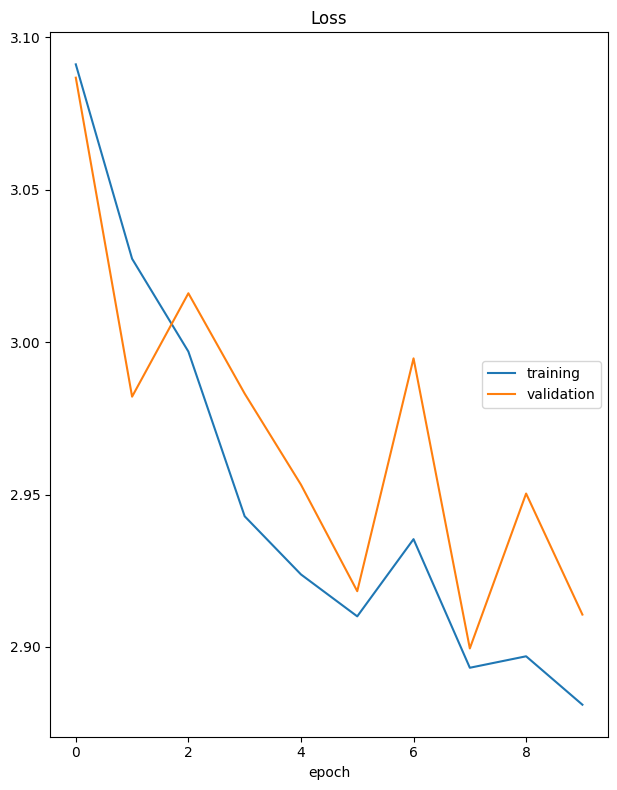

Loss
	training         	 (min:    2.881, max:    3.091, cur:    2.881)
	validation       	 (min:    2.900, max:    3.087, cur:    2.911)


In [ ]:
liveloss = PlotLosses() 
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, clip.model.parameters()), 
    lr=1e-4
)

for epoch in range(10):
    print(f'\nEpoch {epoch + 1}:')
    
    # Тренировка
    clip.model.train()
    train_iterator = tqdm(clip_train, desc='Training', unit='batch')
    train_loss = []

    for images, texts in train_iterator:
        image_latents, text_latents = compute_latents(clip.model, images, texts, clip.device)
        loss = compute_loss(image_latents, text_latents, clip.device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_iterator.set_postfix(loss=loss.item())
        train_loss.append(loss.item())

    # Валидация
    clip.model.eval()
    val_loss = []

    with torch.no_grad():
        val_iterator = tqdm(clip_val, desc='Validation', unit='batch')
        for images, texts in val_iterator:
            image_latents, text_latents = compute_latents(clip.model, images, texts, clip.device)
            loss = compute_loss(image_latents, text_latents, clip.device)

            val_iterator.set_postfix(val_loss=loss.item())
            val_loss.append(loss.item())

    # График
    liveloss.update({
        'loss': sum(train_loss) / len(train_loss),
        'val_loss': sum(val_loss) / len(val_loss),
    })
    liveloss.send()

- Линии трейна и валидации постепенно снижаются — это признак обучаемости модели.
- Validation loss "прыгает", особенно после 6-й эпохи — это может быть из-за маленького размера валидационного набора.
- Датасет в принципе маленький — 993 картинки, даже с 10 подписями это немного (учитывая что оригинальный clip обучался на 37 млн парах картинка-описание).
- Нужно увеличить выборку изображений, желательно хотя бы до нескольких десятков тысяч.
- Учитывая что датасет маленький, модель все равно показала уменьшение функции потерь, что говорит о том, что обучение на датасете сформированный qwen2.5 - хорошая идея!!!

Фиксирую модель и загружаю на [hugging face](https://huggingface.co/bezGriga/ruclip-finetuned-clip993/tree/main)

In [11]:
torch.save(clip.model.state_dict(), 'models/fine-tuned/ruclip_clip993.pt')

Модель загружена на [hugging face](https://huggingface.co/bezGriga/ruclip-finetuned-clip993/tree/main)

Тест работоспособности модели - `models/4. ruclip_clip993.ipynb`